In [22]:
import os # type: ignore
import sys # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns #type: ignore

from tqdm import tqdm # type: ignore

import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.nn.functional as F # type: ignore
import torch.optim as optim # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score # type: ignore
from sklearn.model_selection import train_test_split # type: ignore

import uproot as ur # type: ignore
import pickle # type: ignore
import pandas as pd # type: ignore

import Neural_Net_Helper_Classes as helper
import Neural_Net_Architectures as architecture
import Neural_Net_Datasets as data

print("System Platform: ", sys.platform)
print('System Python Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Numpy version', np.__version__)

System Platform:  linux
System Python Version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
PyTorch version 2.6.0
Numpy version 2.1.3


# Preliminary Data Manipulation

W/o Undersampling:
Training set: (2553918, 11)
Validation set: (547268, 11)
Test set: (547269, 11)
---------------------------------------------------

W/ Undersampling:
Training set: (1547761, 11)
Validation set: (331663, 11)
Test set: (331664, 11)


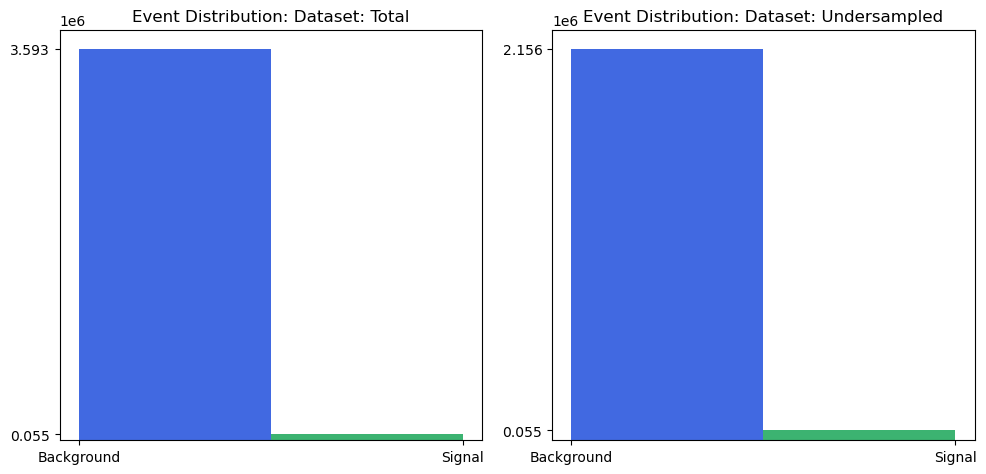

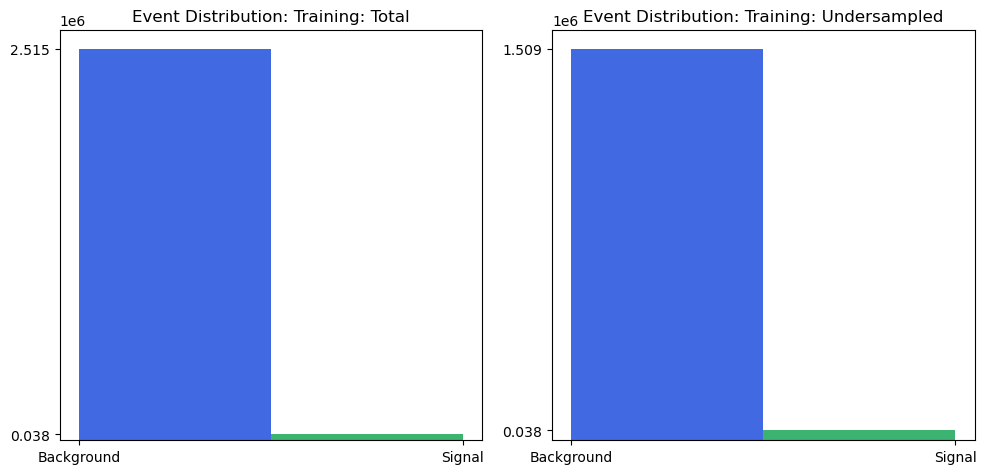

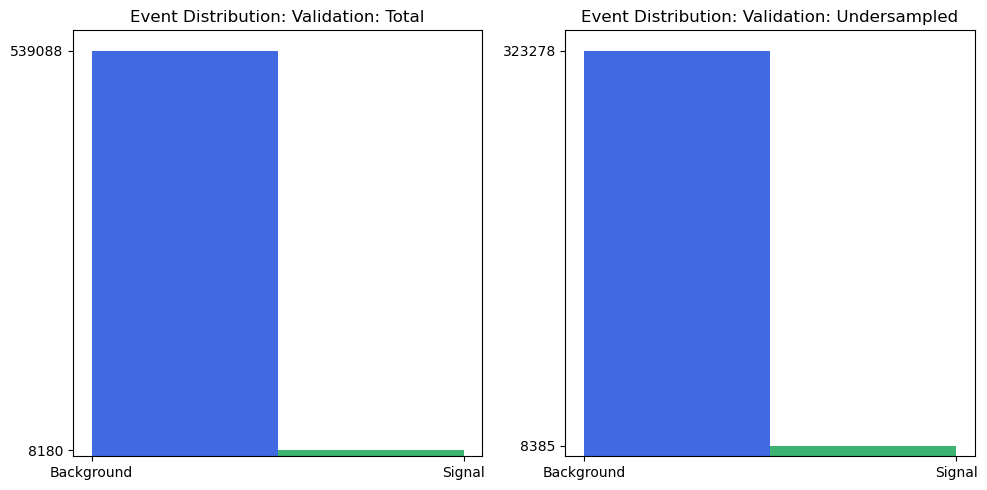

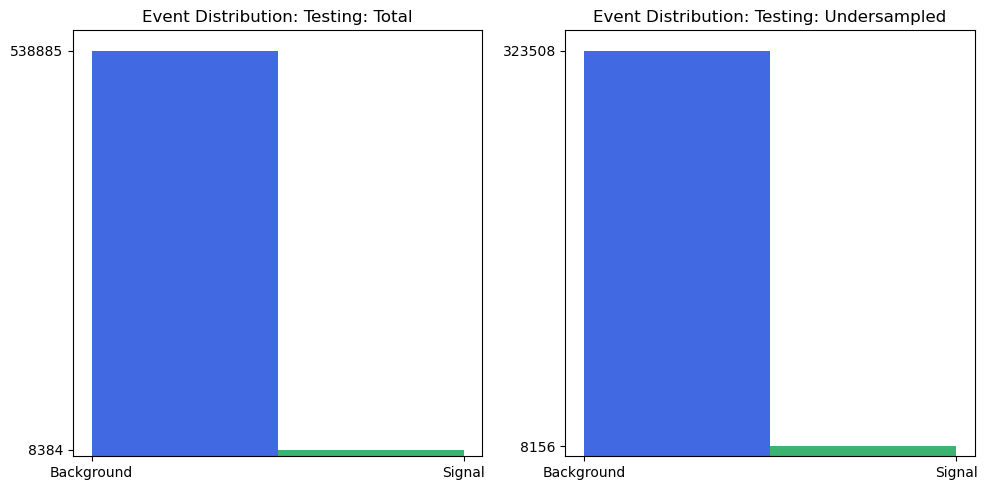

In [2]:
data_manipulator = data.DataManipulator(batch_size=32, transform=data.Normalize(), seed=7)

pickled_data_file_path = "transformed_data.pkl"
pickled_labels_file_path = "transformed_labels.pkl"
background_data_file_name = "train_bkg_data_sideBands_lowQ_wPreselBDT_v5.root"
signal_data_file_name = "train_sig_rare_lowQ_wPreselBDT_v6.root"

undersampling_ratio = 0.6
visualize = True

X, y = data_manipulator.load_all_data(pickled_X=pickled_data_file_path,
                                      pickled_y=pickled_labels_file_path,
                                      uproot_background=background_data_file_name,
                                      uproot_signal=signal_data_file_name)

data_manipulator.undersample_data(undersampling_ratio)
if visualize: data_manipulator.plot_all_compared_event_distributions()

X_train, X_val, X_test = data_manipulator.full_split_data
y_train, y_val, y_test = data_manipulator.full_split_labels

X_u_train, X_u_val, X_u_test = data_manipulator.undersampled_split_data
y_u_train, y_u_val, y_u_test = data_manipulator.undersampled_split_labels

# Dataset & DataLoader Instantiation

In [3]:
training_dataloader, validation_dataloader, test_dataloader = data_manipulator.get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test)
training_u_dataloader, validation_u_dataloader, test_u_dataloader = data_manipulator.get_dataloaders(X_u_train, y_u_train, X_u_val, y_u_val, X_u_test, y_u_test)

# Trainer Instantiation

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainer = architecture.Trainer(training_dataloader, training_u_dataloader, validation_dataloader, validation_u_dataloader, device=device)

# Shallow/Narrow Architecture:
This will be a very simple and smaller model that will act as a performance baseline. It won't have very many layers or very many nodes in each layer. 

Full Architecture can be found in `Neural_Net_Architectures.py`

In [5]:
shallow_narrow_model = architecture.ShallowNarrowModel()
class_weights = torch.tensor([1.0, 1.5], dtype=torch.float)
sn_criterion = nn.CrossEntropyLoss(weight=class_weights)
shallow_narrow_optimizer = optim.Adam(params=shallow_narrow_model.parameters(), lr=0.0001, weight_decay=1e-5)

shallow_narrow_train_losses, shallow_narrow_val_losses = trainer.train_model(model=shallow_narrow_model, optimizer=shallow_narrow_optimizer, num_epochs=5, undersampled=True)

Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2964.61it/s]


Epoch 1/5 - Train loss: 0.04793859603840321, Validation loss: 0.40360327534508567




Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2927.38it/s]


Epoch 2/5 - Train loss: 0.03571673112682844, Validation loss: 0.45197982165346495




Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2826.85it/s]


Epoch 3/5 - Train loss: 0.033638456950398105, Validation loss: 0.5903545283409114




Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2801.57it/s]


Epoch 4/5 - Train loss: 0.03215093947154713, Validation loss: 0.4956118025539748




Validation Loop: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2839.17it/s]

Epoch 5/5 - Train loss: 0.03113408895544076, Validation loss: 0.6038339110565242




# Deep/Narrow Architecture:
There will be more layers in this model, but the amount of nodes per layer will remain relatively smaller. The amount of nodes per layer will also remain balanced.

Full Architecture can be found in `Neural_Net_Architectures.py`

In [7]:
deep_narrow_model = architecture.DeepNarrowModel()
class_weights = torch.tensor([1.0, 1.5], dtype=torch.float)
dn_criterion = nn.CrossEntropyLoss(weight=class_weights)
deep_narrow_optimizer = optim.Adam(params=deep_narrow_model.parameters(), lr=0.0001, weight_decay=1e-5)

deep_narrow_train_losses, deep_narrow_val_losses = trainer.train_model(model=deep_narrow_model, optimizer=deep_narrow_optimizer, num_epochs=5, undersampled=True)

Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2465.69it/s]


Epoch 1/5 - Train loss: 0.05419554566690413, Validation loss: 0.3139556760674212




Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2421.79it/s]


Epoch 2/5 - Train loss: 0.03824128051815373, Validation loss: 0.6614633618480402




Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2454.60it/s]


Epoch 3/5 - Train loss: 0.03544476433558908, Validation loss: 0.8202851549741307




Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2450.94it/s]


Epoch 4/5 - Train loss: 0.03396688058922204, Validation loss: 0.6989945564152436




Validation Loop: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2487.93it/s]

Epoch 5/5 - Train loss: 0.03307077484037569, Validation loss: 0.71460508062718




# Shallow/Wide Architecture: 
There will be relatively less layers in this one, but more nodes in each one. 

Full Architecture can be found in `Neural_Net_Architectures.py`

In [8]:
shallow_wide_model = architecture.ShallowWideModel()
class_weights = torch.tensor([1.0, 1.5], dtype=torch.float)
sn_criterion = nn.CrossEntropyLoss(weight=class_weights)
shallow_wide_optimizer = optim.Adam(params=shallow_wide_model.parameters(), lr=0.0001, weight_decay=1e-5)

shallow_wide_train_losses, shallow_wide_val_losses = trainer.train_model(model=shallow_wide_model, optimizer=shallow_wide_optimizer, num_epochs=5, undersampled=True)

Validation Loop: ShallowWideModel: 100%|██████████| 10365/10365 [00:04<00:00, 2574.02it/s]


Epoch 1/5 - Train loss: 0.04978506327348559, Validation loss: 0.453959925004369




Validation Loop: ShallowWideModel: 100%|██████████| 10365/10365 [00:03<00:00, 2619.20it/s]


Epoch 2/5 - Train loss: 0.03596305014487263, Validation loss: 0.675135546875293




Validation Loop: ShallowWideModel: 100%|██████████| 10365/10365 [00:04<00:00, 2589.18it/s]


Epoch 3/5 - Train loss: 0.03346986271573176, Validation loss: 0.5171452286761462




Validation Loop: ShallowWideModel: 100%|██████████| 10365/10365 [00:04<00:00, 2521.87it/s]


Epoch 4/5 - Train loss: 0.03232850057137694, Validation loss: 0.6783581252290205




Validation Loop: ShallowWideModel: 100%|██████████| 10365/10365 [00:03<00:00, 2592.14it/s]

Epoch 5/5 - Train loss: 0.03169911596432115, Validation loss: 0.34111128695835746




# Deep/Wide Architecture:
This will have the most layers and they will contain the most amount of nodes each.

Full Architecture can be found in `Neural_Net_Architectures.py`

In [9]:
deep_wide_model = architecture.DeepWideModel()
class_weights = torch.tensor([1.0, 1.25], dtype=torch.float)
deep_wide_optimizer = optim.Adam(params=deep_wide_model.parameters(), lr=0.0001, weight_decay=1e-5)
dw_criterion = nn.CrossEntropyLoss(weight=class_weights)

deep_wide_train_losses, deep_wide_val_losses = trainer.train_model(model=deep_wide_model, optimizer=deep_wide_optimizer, num_epochs=5, undersampled=True, criterion=dw_criterion)

Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:05<00:00, 1855.12it/s]


Epoch 1/5 - Train loss: 0.0685866091431778, Validation loss: 0.2684019096355307




Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:06<00:00, 1522.84it/s]


Epoch 2/5 - Train loss: 0.04712013347395188, Validation loss: 0.6538458832843675




Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:07<00:00, 1460.62it/s]


Epoch 3/5 - Train loss: 0.04238635742182773, Validation loss: 0.6641702938694026




Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:07<00:00, 1414.23it/s]


Epoch 4/5 - Train loss: 0.04021539398681235, Validation loss: 0.7421049451057963




Validation Loop: DeepWideModel: 100%|██████████| 10365/10365 [00:07<00:00, 1373.13it/s]

Epoch 5/5 - Train loss: 0.03896126758788824, Validation loss: 0.6794598999010585




# Results

In [10]:
results_builder = helper.ResultsBuilder(test_dataloader, test_u_dataloader, device=device)

Accuracy Calculation: ShallowNarrowModel: 100%|██████████| 17103/17103 [00:06<00:00, 2813.45it/s]


Full Dataset Test Accuracy: 97.24%


Accuracy Calculation: ShallowNarrowModel: 100%|██████████| 10365/10365 [00:03<00:00, 2890.54it/s]


Undersampled Dataset Test Accuracy: 97.73%


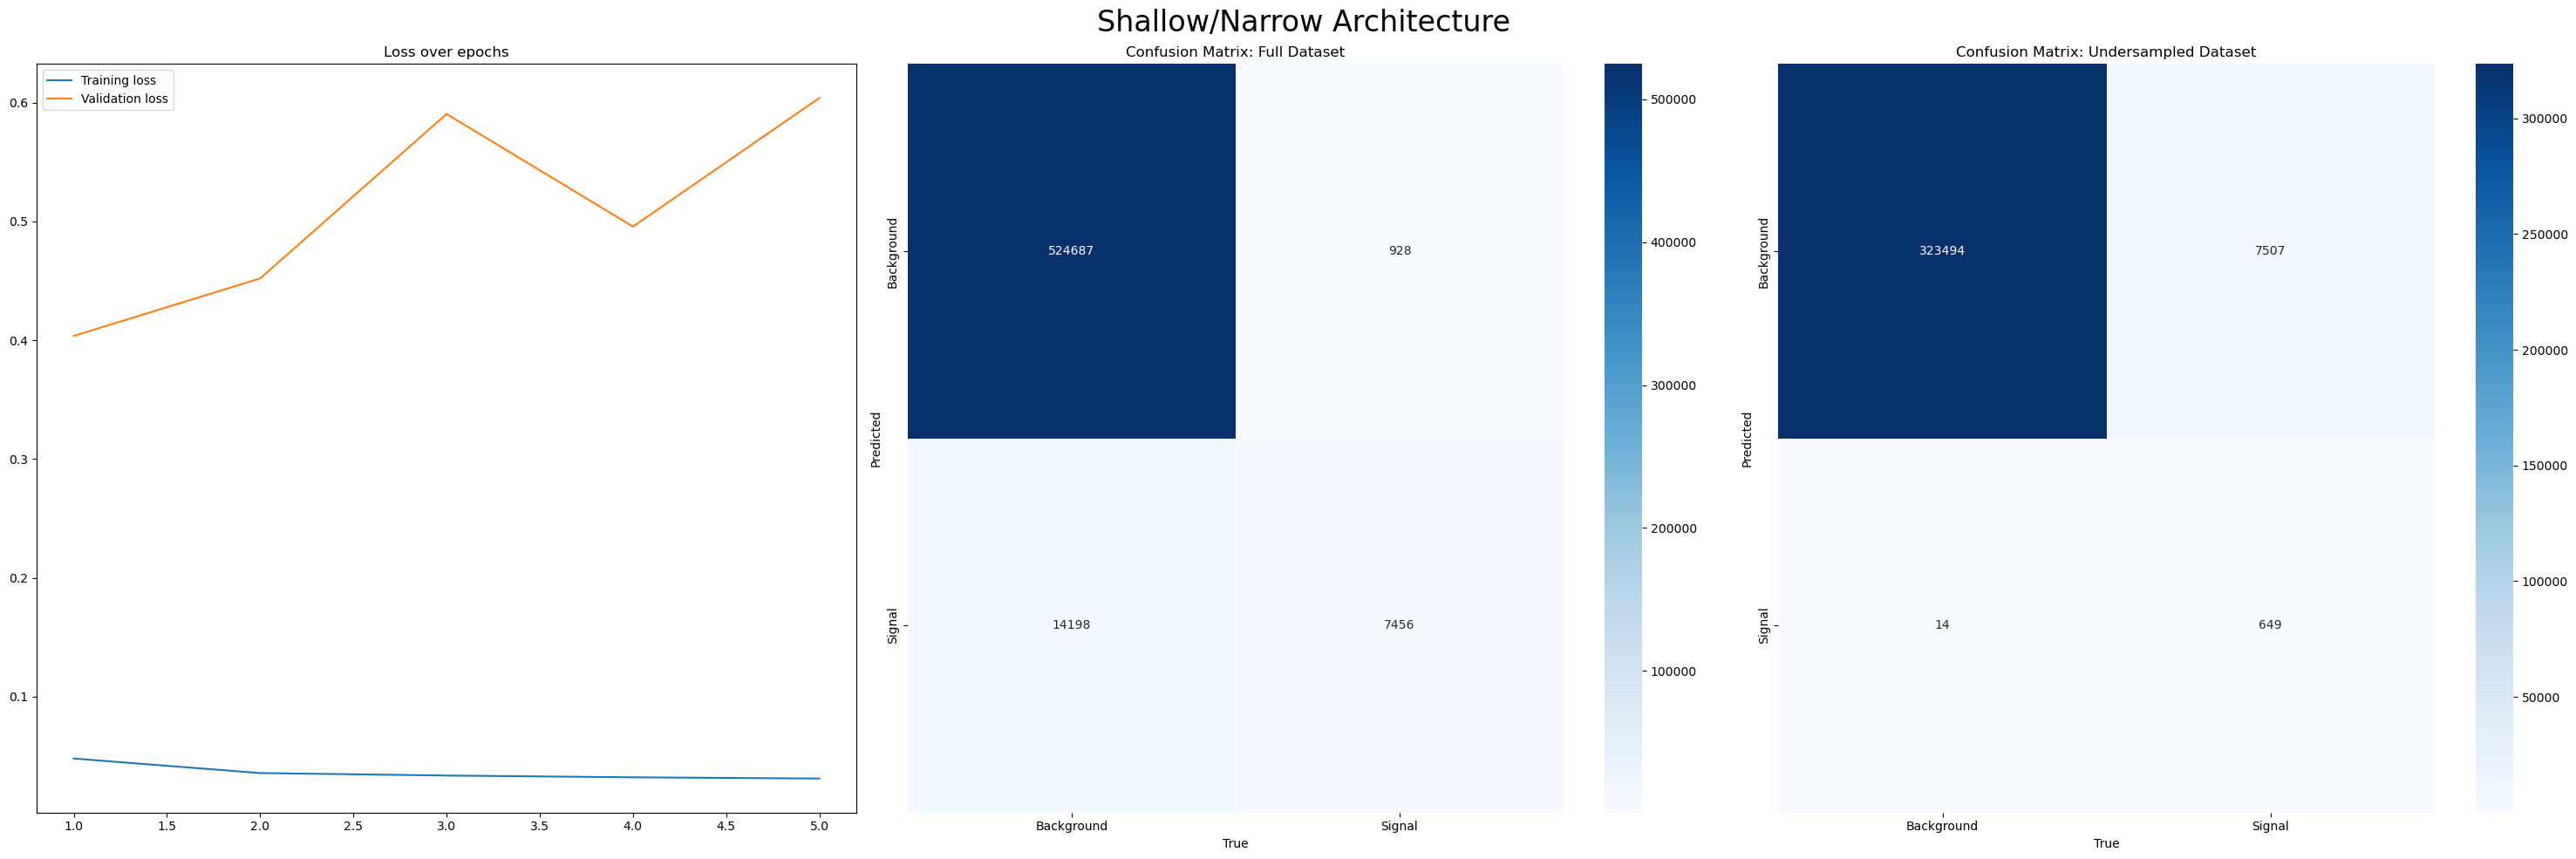

Accuracy Calculation: DeepNarrowModel: 100%|██████████| 17103/17103 [00:06<00:00, 2531.16it/s]


Full Dataset Test Accuracy: 99.18%


Accuracy Calculation: DeepNarrowModel: 100%|██████████| 10365/10365 [00:04<00:00, 2484.36it/s]


Undersampled Dataset Test Accuracy: 97.71%


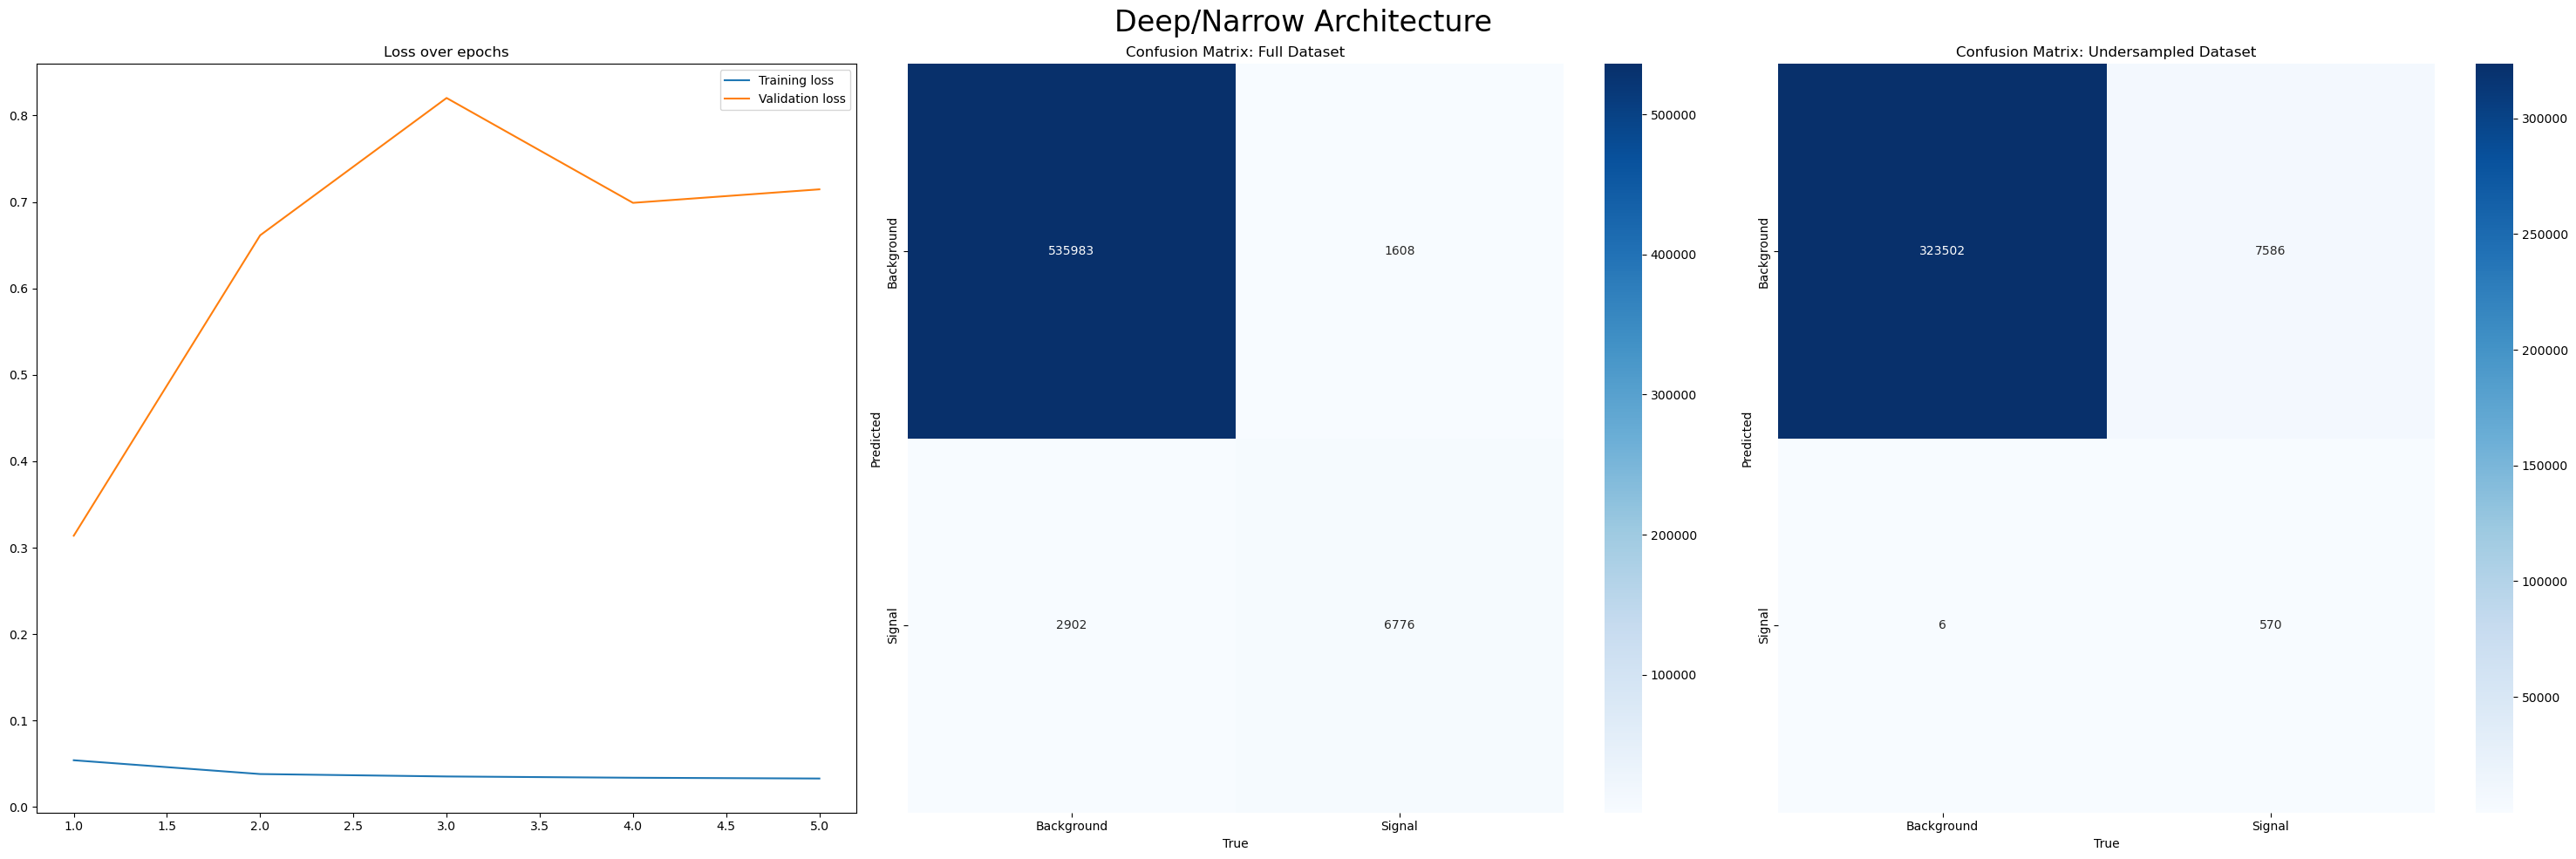

Accuracy Calculation: ShallowWideModel: 100%|██████████| 17103/17103 [00:06<00:00, 2580.93it/s]


Full Dataset Test Accuracy: 99.32%


Accuracy Calculation: ShallowWideModel: 100%|██████████| 10365/10365 [00:04<00:00, 2512.39it/s]


Undersampled Dataset Test Accuracy: 97.67%


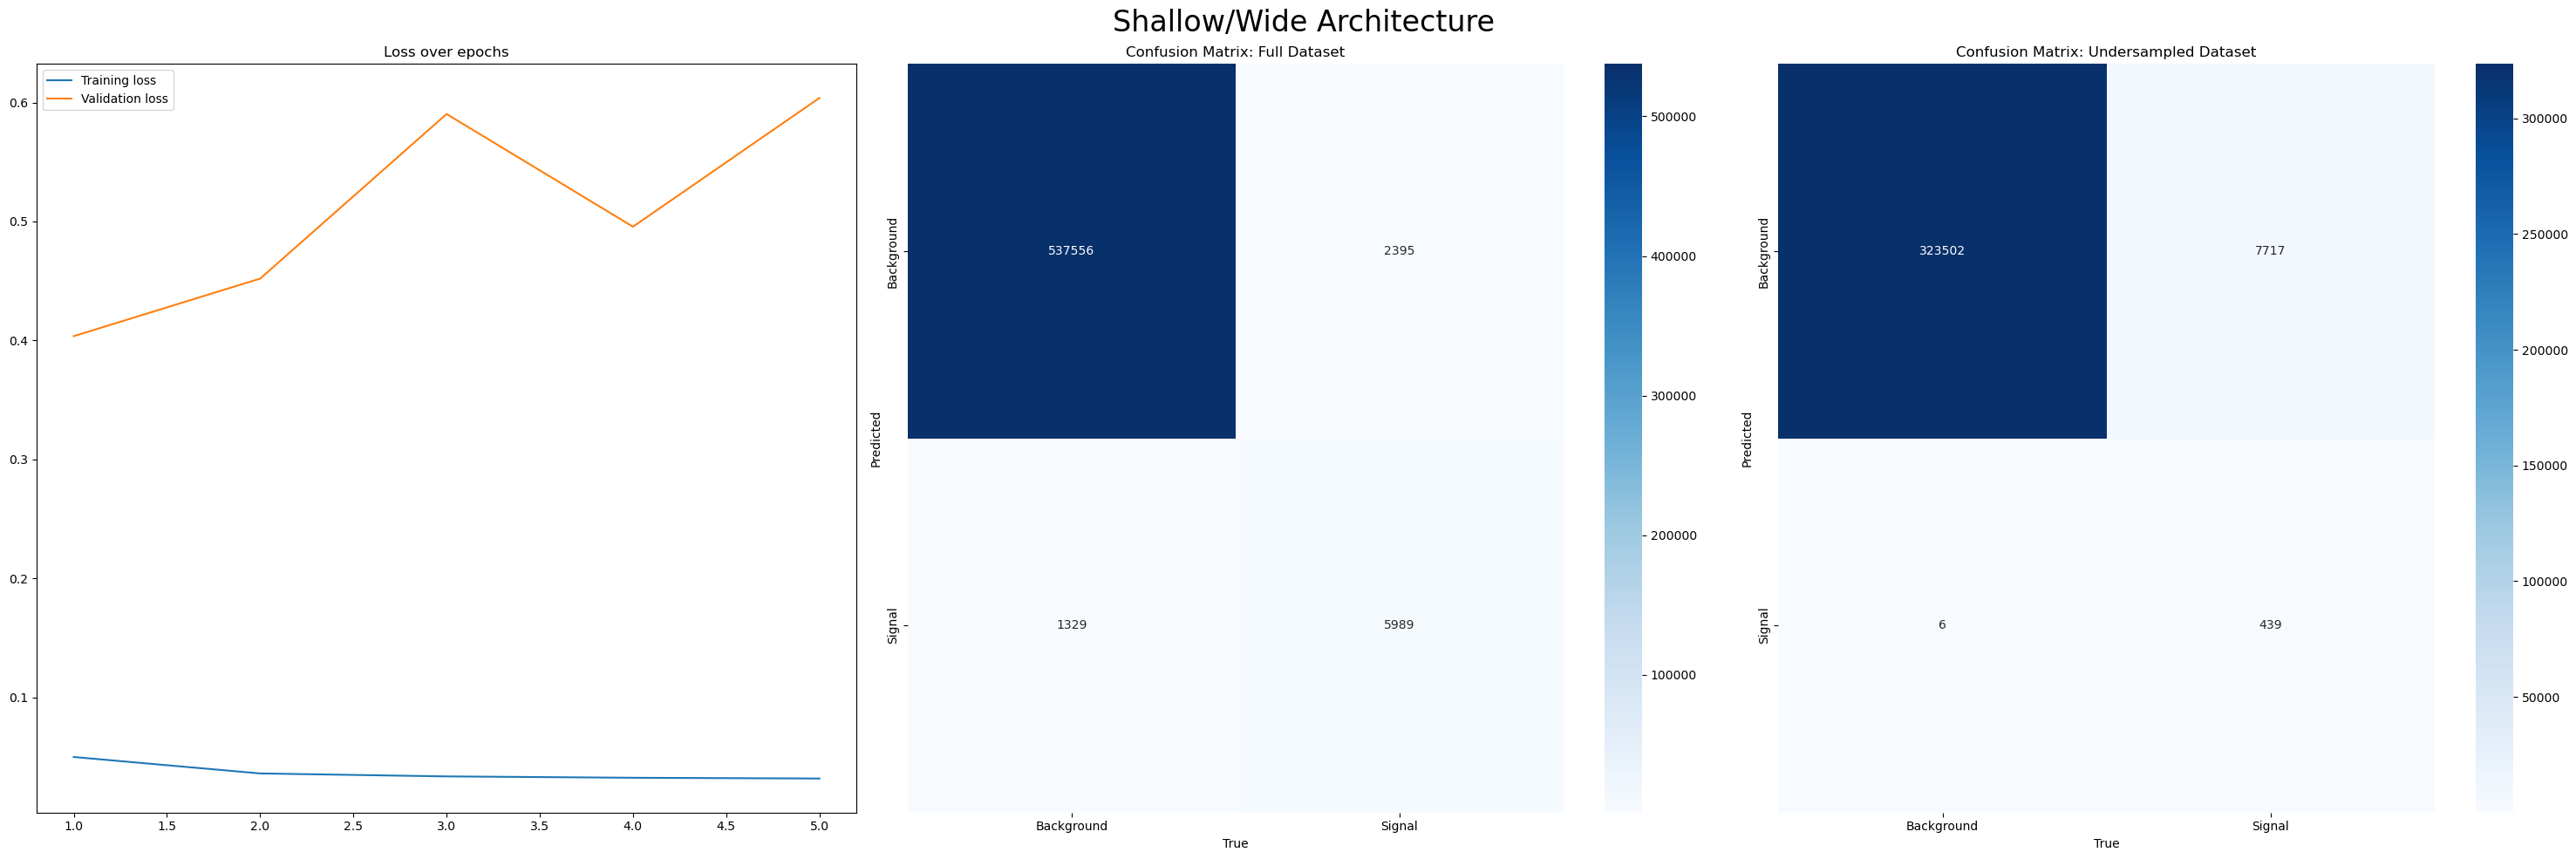

Accuracy Calculation: DeepWideModel: 100%|██████████| 17103/17103 [00:10<00:00, 1609.86it/s]


Full Dataset Test Accuracy: 97.84%


Accuracy Calculation: DeepWideModel: 100%|██████████| 10365/10365 [00:05<00:00, 1824.97it/s]


Undersampled Dataset Test Accuracy: 97.71%


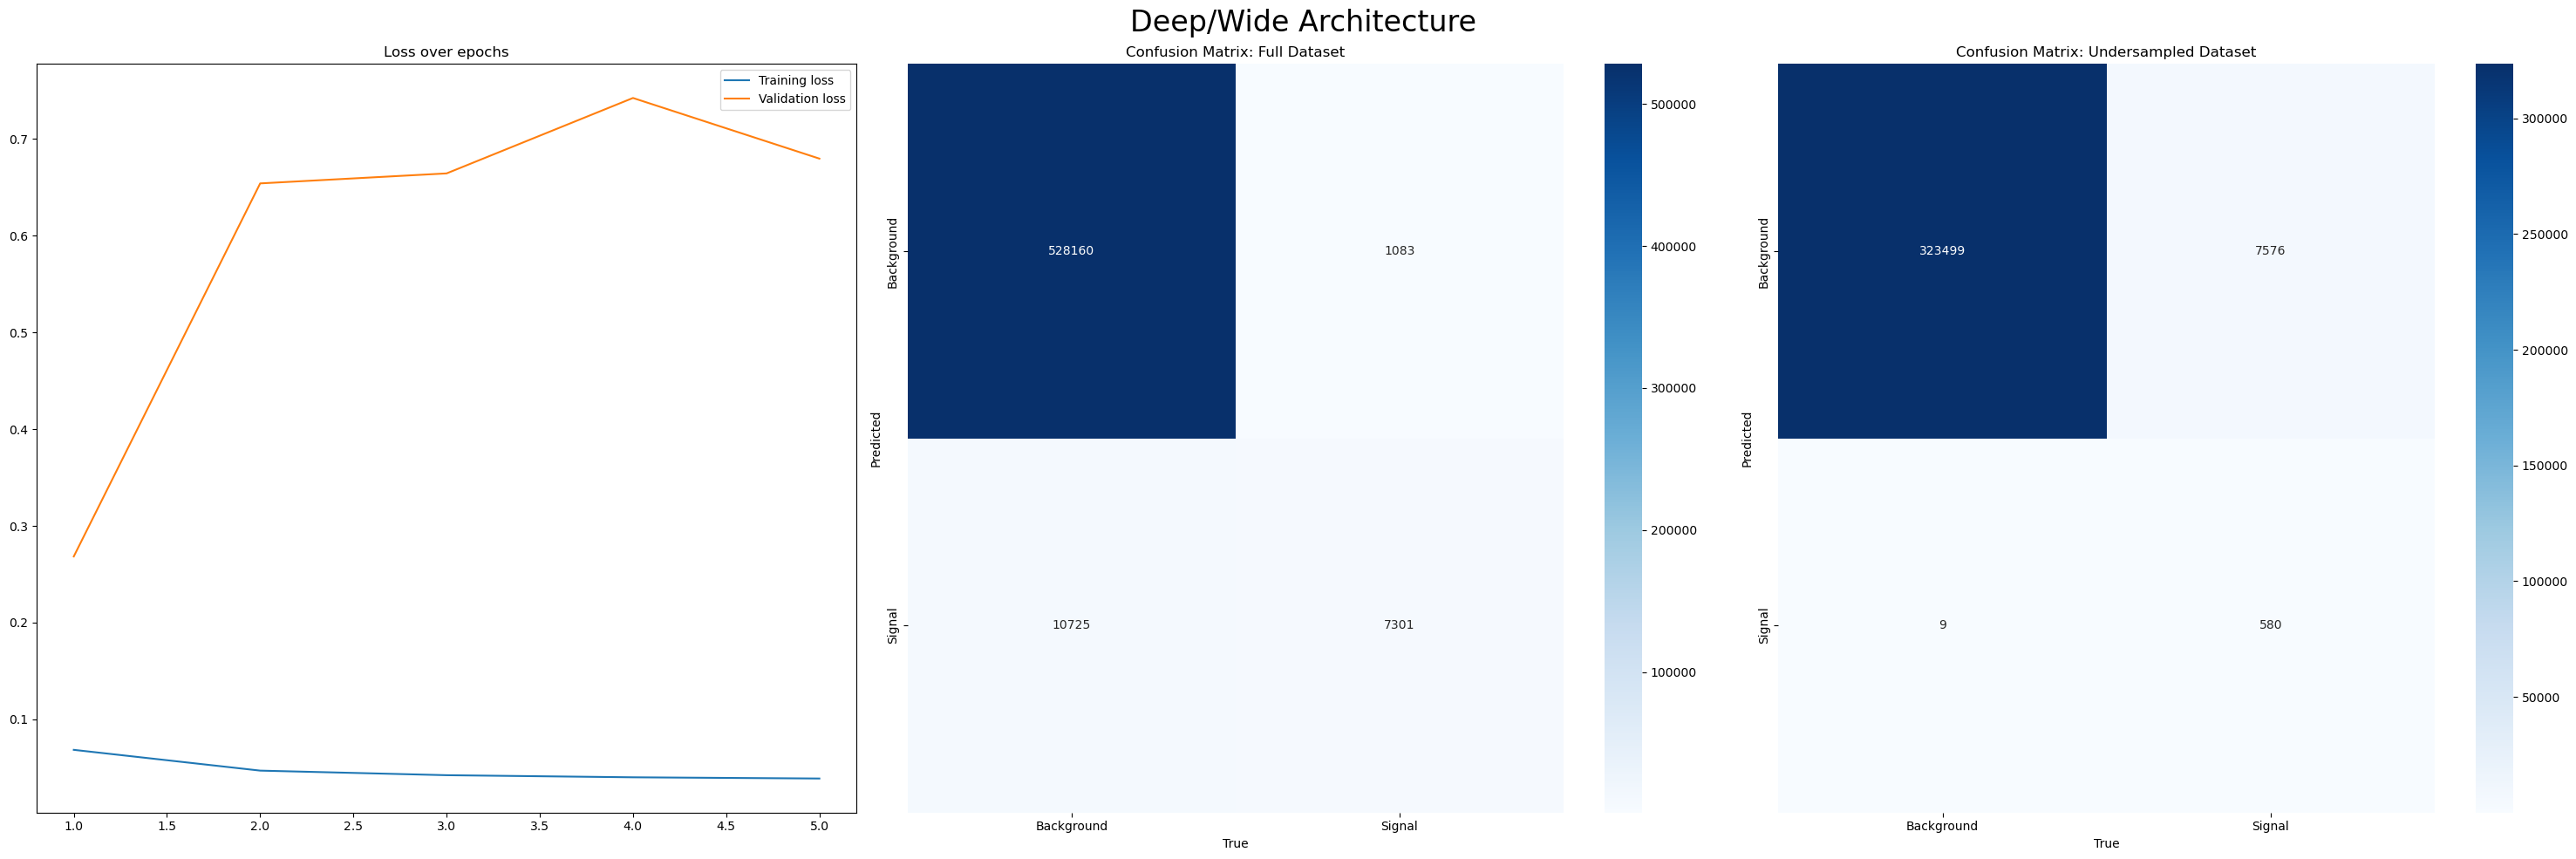

In [11]:
results_builder.plot_model_performance(model=shallow_narrow_model, model_name="Shallow/Narrow", train_loss=shallow_narrow_train_losses, val_loss=shallow_narrow_val_losses)
results_builder.plot_model_performance(model=deep_narrow_model, model_name="Deep/Narrow", train_loss=deep_narrow_train_losses, val_loss=deep_narrow_val_losses)
results_builder.plot_model_performance(model=shallow_wide_model, model_name="Shallow/Wide", train_loss=shallow_wide_train_losses, val_loss=shallow_narrow_val_losses)
results_builder.plot_model_performance(model=deep_wide_model, model_name="Deep/Wide", train_loss=deep_wide_train_losses, val_loss=deep_wide_val_losses)

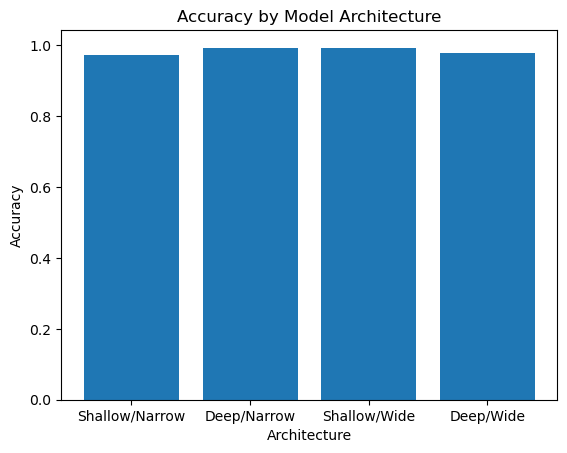

In [12]:
results_builder.plot_accuracy_by_architecture()

In [23]:
def calculate_accuracy(model: nn.Module, undersampled: bool = False):
        model.eval()
        model.to(device)
        all_predictions = []
        all_labels = []
        description = f"Accuracy Calculation: {model.__class__.__name__}"

        tester = test_dataloader if undersampled == False else test_u_dataloader

        with torch.no_grad():
            for events, labels in tqdm(tester, desc=description):
                outputs = model(events)
                _, predicted = torch.max(outputs, 1)

                all_predictions.append(predicted.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        all_predictions = np.concatenate(all_predictions)
        all_labels = np.concatenate(all_labels)

        accuracy = accuracy_score(all_labels, all_predictions)
        tst_str = "Full Dataset Test Accuracy:" if undersampled == False else "Undersampled Dataset Test Accuracy:"
        print(f"{tst_str} {accuracy * 100:.2f}%")

        cm = confusion_matrix(all_predictions, all_labels)
        recall = recall_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions)

        return accuracy, recall, precision, f1, cm

In [26]:
precisions, recalls, f1s, accuracies, cms = {}, {}, {}, {}, {}
def append_everything(model: nn.Module, name:str):
    acc, recall, prec, f1, cm = calculate_accuracy(model)
    accuracies[name] = acc
    recalls[name] = recall
    f1s[name] = f1
    precisions[name] = prec
    cms[name] = cm

append_everything(shallow_narrow_model, "Shallow/Narrow")
append_everything(deep_narrow_model, "Deep/Narrow")
append_everything(shallow_wide_model, "Shallow/Wide")
append_everything(deep_wide_model, "Deep/Wide")

print(precisions)
print(recalls)
print(f1s)
print(accuracies)

Accuracy Calculation: ShallowNarrowModel: 100%|██████████| 17103/17103 [00:06<00:00, 2786.76it/s]


Full Dataset Test Accuracy: 97.24%


Accuracy Calculation: DeepNarrowModel: 100%|██████████| 17103/17103 [00:06<00:00, 2494.56it/s]


Full Dataset Test Accuracy: 99.18%


Accuracy Calculation: ShallowWideModel: 100%|██████████| 17103/17103 [00:07<00:00, 2244.14it/s]


Full Dataset Test Accuracy: 99.32%


Accuracy Calculation: DeepWideModel: 100%|██████████| 17103/17103 [00:10<00:00, 1584.82it/s]


Full Dataset Test Accuracy: 97.84%
{'Shallow/Narrow': 0.3443243742495613, 'Deep/Narrow': 0.7001446579871874, 'Shallow/Wide': 0.8183930035528832, 'Deep/Wide': 0.4050260734494619}
{'Shallow/Narrow': 0.8893129770992366, 'Deep/Narrow': 0.808206106870229, 'Shallow/Wide': 0.7143368320610687, 'Deep/Wide': 0.8708253816793893}
{'Shallow/Narrow': 0.49643784539583197, 'Deep/Narrow': 0.7503045066991474, 'Shallow/Wide': 0.7628327601579417, 'Deep/Wide': 0.5528966300643695}
{'Shallow/Narrow': 0.9723609413286701, 'Deep/Narrow': 0.9917590800867581, 'Shallow/Wide': 0.993195302492924, 'Deep/Wide': 0.9784237733180575}


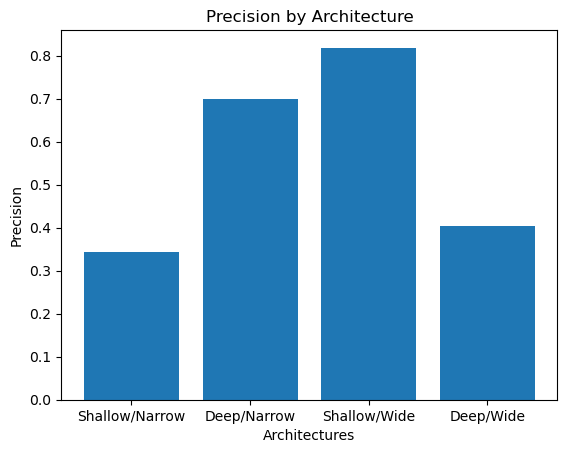

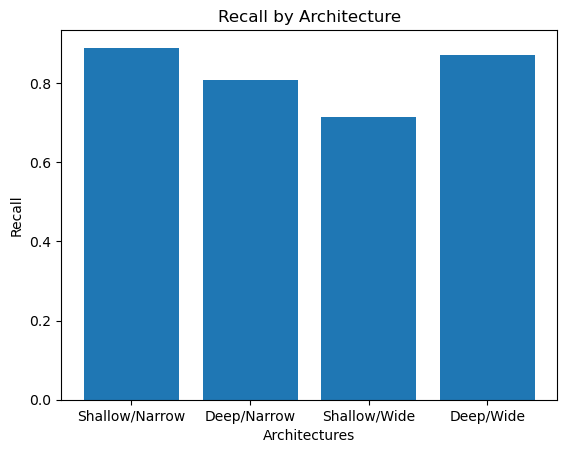

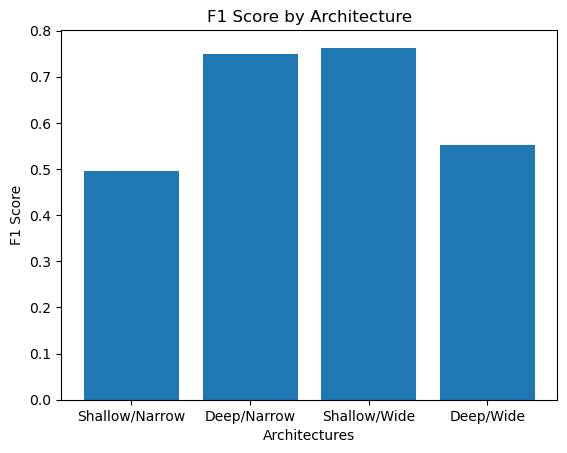

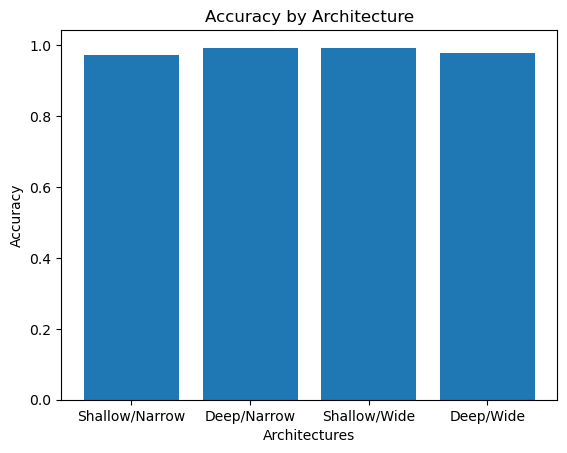

In [27]:
def plot_dictionary(dictionary:dict, xlabel:str, ylabel:str, title:str):
        keys = list(dictionary.keys())
        values = list(dictionary.values())

        plt.bar(keys, values)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)

        plt.show()

plot_dictionary(precisions, "Architectures", "Precision", "Precision by Architecture")
plot_dictionary(recalls, "Architectures", "Recall", "Recall by Architecture")
plot_dictionary(f1s, "Architectures", "F1 Score", "F1 Score by Architecture")
plot_dictionary(accuracies, "Architectures", "Accuracy", "Accuracy by Architecture")

# Model Exports

In [ ]:
should_save_shallow_narrow = False
should_save_shallow_wide = False
should_save_deep_narrow = False
should_save_deep_wide = False

saver = helper.ModelSaver()

AttributeError: module 'Neural_Net_Helper_Classes' has no attribute 'ModelSaver'

In [ ]:
if should_save_shallow_narrow == True:  
    saver.export(model=shallow_narrow_model, filename="shallow_narrow_full_model", full_architecture=True)
    saver.export(model=shallow_narrow_model, filename="shallow_narrow_model_parameters", full_architecture=False)
if should_save_shallow_wide == True:
    saver.export(model=shallow_wide_model, filename="shallow_wide_full_model", full_architecture=True)
    saver.export(model=shallow_wide_model, filename="shallow_wide_model_parameters", full_architecture=False)
if should_save_deep_narrow == True:
    saver.export(model=deep_narrow_model, filename="deep_narrow_full_model", full_architecture=True)
    saver.export(model=deep_narrow_model, filename="deep_narrow_model_parameters", full_architecture=False)
if should_save_deep_wide == True:
    saver.export(model=deep_wide_model, filename="deep_wide_full_model", full_architecture=True)
    saver.export(model=deep_wide_model, filename="deep_wide_model_parameters", full_architecture=False)

shallow_narrow_full_model.pt successfully saved to directory
shallow_narrow_model_parameters.pth successfully saved to directory
shallow_wide_full_model.pt successfully saved to directory
shallow_wide_model_parameters.pth successfully saved to directory
deep_narrow_full_model.pt successfully saved to directory
deep_narrow_model_parameters.pth successfully saved to directory
deep_wide_full_model.pt successfully saved to directory
deep_wide_model_parameters.pth successfully saved to directory
